In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 64
learning_rate = 0.00001

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='emotion5/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion5/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([64, 3, 48, 48])
out-size: torch.Size([3, 402, 402])


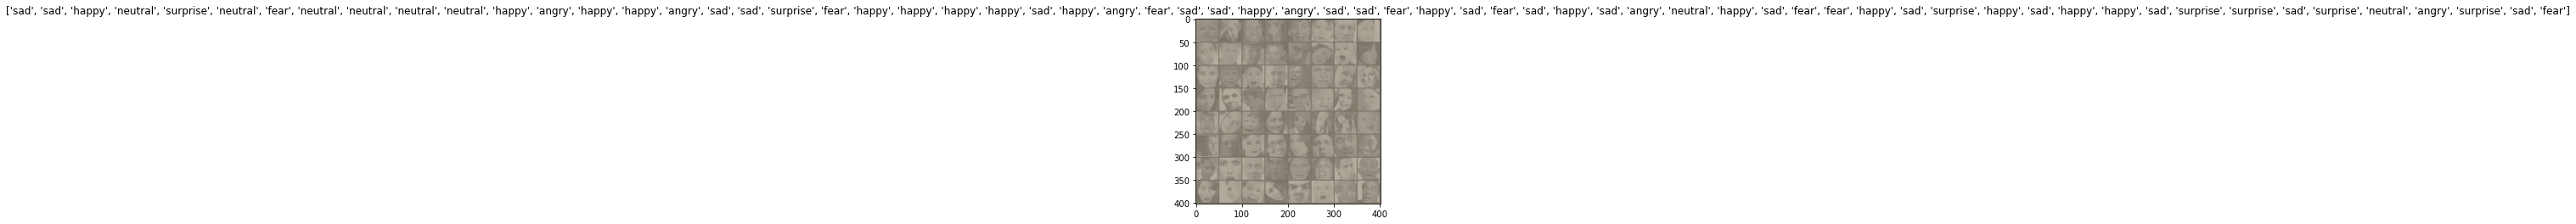

In [4]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [5]:
net = models.resnet50(pretrained=True)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 48)
net.fc = net.fc.cuda() if device else net.fc

In [7]:
n_epochs = 150
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet_adam_batch64_lr00001_nnlinear48_learning00001.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/150], Step [0/442], Loss: 3.9108
Epoch [1/150], Step [20/442], Loss: 3.7734
Epoch [1/150], Step [40/442], Loss: 3.8274
Epoch [1/150], Step [60/442], Loss: 3.7721
Epoch [1/150], Step [80/442], Loss: 3.8180
Epoch [1/150], Step [100/442], Loss: 3.6929
Epoch [1/150], Step [120/442], Loss: 3.6279
Epoch [1/150], Step [140/442], Loss: 3.5970
Epoch [1/150], Step [160/442], Loss: 3.3620
Epoch [1/150], Step [180/442], Loss: 3.1731
Epoch [1/150], Step [200/442], Loss: 3.4526
Epoch [1/150], Step [220/442], Loss: 3.0700
Epoch [1/150], Step [240/442], Loss: 3.0027
Epoch [1/150], Step [260/442], Loss: 3.2159
Epoch [1/150], Step [280/442], Loss: 2.9345
Epoch [1/150], Step [300/442], Loss: 3.1212
Epoch [1/150], Step [320/442], Loss: 2.7383
Epoch [1/150], Step [340/442], Loss: 3.3532
Epoch [1/150], Step [360/442], Loss: 2.8852
Epoch [1/150], Step [380/442], Loss: 2.5204
Epoch [1/150], Step [400/442], Loss: 2.2562
Epoch [1/150], Step [420/442], Loss: 2.2160
Epoch [1/150], Step [440/442]

Epoch [8/150], Step [160/442], Loss: 0.3901
Epoch [8/150], Step [180/442], Loss: 0.3632
Epoch [8/150], Step [200/442], Loss: 0.2133
Epoch [8/150], Step [220/442], Loss: 0.2555
Epoch [8/150], Step [240/442], Loss: 0.3043
Epoch [8/150], Step [260/442], Loss: 0.3274
Epoch [8/150], Step [280/442], Loss: 0.2894
Epoch [8/150], Step [300/442], Loss: 0.4327
Epoch [8/150], Step [320/442], Loss: 0.4319
Epoch [8/150], Step [340/442], Loss: 0.3673
Epoch [8/150], Step [360/442], Loss: 0.4557
Epoch [8/150], Step [380/442], Loss: 0.3153
Epoch [8/150], Step [400/442], Loss: 0.4267
Epoch [8/150], Step [420/442], Loss: 0.2863
Epoch [8/150], Step [440/442], Loss: 0.3653

train-loss: 1.2584, train-acc: 89.6969
validation loss: 1.8369, validation acc: 55.5681

Epoch 9

Epoch [9/150], Step [0/442], Loss: 0.2728
Epoch [9/150], Step [20/442], Loss: 0.1697
Epoch [9/150], Step [40/442], Loss: 0.2024
Epoch [9/150], Step [60/442], Loss: 0.3746
Epoch [9/150], Step [80/442], Loss: 0.2339
Epoch [9/150], Step [100/44

Epoch [15/150], Step [320/442], Loss: 0.0332
Epoch [15/150], Step [340/442], Loss: 0.0379
Epoch [15/150], Step [360/442], Loss: 0.0817
Epoch [15/150], Step [380/442], Loss: 0.1653
Epoch [15/150], Step [400/442], Loss: 0.0373
Epoch [15/150], Step [420/442], Loss: 0.0253
Epoch [15/150], Step [440/442], Loss: 0.1249

train-loss: 0.7367, train-acc: 97.9380
validation loss: 2.0001, validation acc: 56.2898

Epoch 16

Epoch [16/150], Step [0/442], Loss: 0.0578
Epoch [16/150], Step [20/442], Loss: 0.1292
Epoch [16/150], Step [40/442], Loss: 0.0348
Epoch [16/150], Step [60/442], Loss: 0.0431
Epoch [16/150], Step [80/442], Loss: 0.0753
Epoch [16/150], Step [100/442], Loss: 0.0771
Epoch [16/150], Step [120/442], Loss: 0.0223
Epoch [16/150], Step [140/442], Loss: 0.0376
Epoch [16/150], Step [160/442], Loss: 0.0373
Epoch [16/150], Step [180/442], Loss: 0.0507
Epoch [16/150], Step [200/442], Loss: 0.0160
Epoch [16/150], Step [220/442], Loss: 0.0452
Epoch [16/150], Step [240/442], Loss: 0.0571
Epoch 

validation loss: 2.1337, validation acc: 55.9502

Epoch 23

Epoch [23/150], Step [0/442], Loss: 0.0054
Epoch [23/150], Step [20/442], Loss: 0.0332
Epoch [23/150], Step [40/442], Loss: 0.0313
Epoch [23/150], Step [60/442], Loss: 0.0071
Epoch [23/150], Step [80/442], Loss: 0.0193
Epoch [23/150], Step [100/442], Loss: 0.0287
Epoch [23/150], Step [120/442], Loss: 0.0152
Epoch [23/150], Step [140/442], Loss: 0.0198
Epoch [23/150], Step [160/442], Loss: 0.0244
Epoch [23/150], Step [180/442], Loss: 0.0086
Epoch [23/150], Step [200/442], Loss: 0.2864
Epoch [23/150], Step [220/442], Loss: 0.0180
Epoch [23/150], Step [240/442], Loss: 0.0142
Epoch [23/150], Step [260/442], Loss: 0.0140
Epoch [23/150], Step [280/442], Loss: 0.0120
Epoch [23/150], Step [300/442], Loss: 0.0499
Epoch [23/150], Step [320/442], Loss: 0.0457
Epoch [23/150], Step [340/442], Loss: 0.0783
Epoch [23/150], Step [360/442], Loss: 0.0186
Epoch [23/150], Step [380/442], Loss: 0.0115
Epoch [23/150], Step [400/442], Loss: 0.0123
E

Epoch [30/150], Step [120/442], Loss: 0.0254
Epoch [30/150], Step [140/442], Loss: 0.0227
Epoch [30/150], Step [160/442], Loss: 0.0163
Epoch [30/150], Step [180/442], Loss: 0.0043
Epoch [30/150], Step [200/442], Loss: 0.0461
Epoch [30/150], Step [220/442], Loss: 0.1668
Epoch [30/150], Step [240/442], Loss: 0.0350
Epoch [30/150], Step [260/442], Loss: 0.0275
Epoch [30/150], Step [280/442], Loss: 0.0337
Epoch [30/150], Step [300/442], Loss: 0.1263
Epoch [30/150], Step [320/442], Loss: 0.0094
Epoch [30/150], Step [340/442], Loss: 0.0071
Epoch [30/150], Step [360/442], Loss: 0.0082
Epoch [30/150], Step [380/442], Loss: 0.0221
Epoch [30/150], Step [400/442], Loss: 0.0247
Epoch [30/150], Step [420/442], Loss: 0.0178
Epoch [30/150], Step [440/442], Loss: 0.0529

train-loss: 0.3910, train-acc: 99.0026
validation loss: 2.2312, validation acc: 57.2803

Epoch 31

Epoch [31/150], Step [0/442], Loss: 0.0127
Epoch [31/150], Step [20/442], Loss: 0.0135
Epoch [31/150], Step [40/442], Loss: 0.0311
Epoc

Epoch [37/150], Step [260/442], Loss: 0.0172
Epoch [37/150], Step [280/442], Loss: 0.1024
Epoch [37/150], Step [300/442], Loss: 0.0773
Epoch [37/150], Step [320/442], Loss: 0.0385
Epoch [37/150], Step [340/442], Loss: 0.0094
Epoch [37/150], Step [360/442], Loss: 0.0329
Epoch [37/150], Step [380/442], Loss: 0.0351
Epoch [37/150], Step [400/442], Loss: 0.0135
Epoch [37/150], Step [420/442], Loss: 0.0081
Epoch [37/150], Step [440/442], Loss: 0.0234

train-loss: 0.3225, train-acc: 99.2714
validation loss: 2.2843, validation acc: 58.2425

Epoch 38

Epoch [38/150], Step [0/442], Loss: 0.0408
Epoch [38/150], Step [20/442], Loss: 0.0053
Epoch [38/150], Step [40/442], Loss: 0.0146
Epoch [38/150], Step [60/442], Loss: 0.0055
Epoch [38/150], Step [80/442], Loss: 0.0233
Epoch [38/150], Step [100/442], Loss: 0.0050
Epoch [38/150], Step [120/442], Loss: 0.0025
Epoch [38/150], Step [140/442], Loss: 0.0065
Epoch [38/150], Step [160/442], Loss: 0.0103
Epoch [38/150], Step [180/442], Loss: 0.0593
Epoch 

Epoch [44/150], Step [400/442], Loss: 0.0092
Epoch [44/150], Step [420/442], Loss: 0.0165
Epoch [44/150], Step [440/442], Loss: 0.0175

train-loss: 0.2751, train-acc: 99.3527
validation loss: 2.3215, validation acc: 58.0020

Epoch 45

Epoch [45/150], Step [0/442], Loss: 0.0126
Epoch [45/150], Step [20/442], Loss: 0.0016
Epoch [45/150], Step [40/442], Loss: 0.0378
Epoch [45/150], Step [60/442], Loss: 0.0045
Epoch [45/150], Step [80/442], Loss: 0.0050
Epoch [45/150], Step [100/442], Loss: 0.0628
Epoch [45/150], Step [120/442], Loss: 0.0042
Epoch [45/150], Step [140/442], Loss: 0.0070
Epoch [45/150], Step [160/442], Loss: 0.0061
Epoch [45/150], Step [180/442], Loss: 0.0262
Epoch [45/150], Step [200/442], Loss: 0.0060
Epoch [45/150], Step [220/442], Loss: 0.0321
Epoch [45/150], Step [240/442], Loss: 0.0034
Epoch [45/150], Step [260/442], Loss: 0.0044
Epoch [45/150], Step [280/442], Loss: 0.0078
Epoch [45/150], Step [300/442], Loss: 0.0301
Epoch [45/150], Step [320/442], Loss: 0.0118
Epoch 

Epoch [52/150], Step [40/442], Loss: 0.0074
Epoch [52/150], Step [60/442], Loss: 0.0045
Epoch [52/150], Step [80/442], Loss: 0.0097
Epoch [52/150], Step [100/442], Loss: 0.0244
Epoch [52/150], Step [120/442], Loss: 0.0144
Epoch [52/150], Step [140/442], Loss: 0.0347
Epoch [52/150], Step [160/442], Loss: 0.0064
Epoch [52/150], Step [180/442], Loss: 0.0074
Epoch [52/150], Step [200/442], Loss: 0.0021
Epoch [52/150], Step [220/442], Loss: 0.0047
Epoch [52/150], Step [240/442], Loss: 0.0054
Epoch [52/150], Step [260/442], Loss: 0.0109
Epoch [52/150], Step [280/442], Loss: 0.0050
Epoch [52/150], Step [300/442], Loss: 0.0339
Epoch [52/150], Step [320/442], Loss: 0.0069
Epoch [52/150], Step [340/442], Loss: 0.0896
Epoch [52/150], Step [360/442], Loss: 0.0028
Epoch [52/150], Step [380/442], Loss: 0.0185
Epoch [52/150], Step [400/442], Loss: 0.0092
Epoch [52/150], Step [420/442], Loss: 0.0097
Epoch [52/150], Step [440/442], Loss: 0.0075

train-loss: 0.2363, train-acc: 99.2820
validation loss: 2

Epoch [59/150], Step [180/442], Loss: 0.0202
Epoch [59/150], Step [200/442], Loss: 0.0061
Epoch [59/150], Step [220/442], Loss: 0.0022
Epoch [59/150], Step [240/442], Loss: 0.0373
Epoch [59/150], Step [260/442], Loss: 0.0402
Epoch [59/150], Step [280/442], Loss: 0.0031
Epoch [59/150], Step [300/442], Loss: 0.0521
Epoch [59/150], Step [320/442], Loss: 0.0024
Epoch [59/150], Step [340/442], Loss: 0.0060
Epoch [59/150], Step [360/442], Loss: 0.0331
Epoch [59/150], Step [380/442], Loss: 0.0041
Epoch [59/150], Step [400/442], Loss: 0.0037
Epoch [59/150], Step [420/442], Loss: 0.0415
Epoch [59/150], Step [440/442], Loss: 0.0095

train-loss: 0.2106, train-acc: 99.4164
validation loss: 2.3813, validation acc: 59.0916

Epoch 60

Epoch [60/150], Step [0/442], Loss: 0.0019
Epoch [60/150], Step [20/442], Loss: 0.0312
Epoch [60/150], Step [40/442], Loss: 0.0016
Epoch [60/150], Step [60/442], Loss: 0.0025
Epoch [60/150], Step [80/442], Loss: 0.0028
Epoch [60/150], Step [100/442], Loss: 0.0499
Epoch 

Epoch [66/150], Step [320/442], Loss: 0.0022
Epoch [66/150], Step [340/442], Loss: 0.0080
Epoch [66/150], Step [360/442], Loss: 0.0123
Epoch [66/150], Step [380/442], Loss: 0.0286
Epoch [66/150], Step [400/442], Loss: 0.0043
Epoch [66/150], Step [420/442], Loss: 0.0198
Epoch [66/150], Step [440/442], Loss: 0.0493

train-loss: 0.1902, train-acc: 99.2714
validation loss: 2.4024, validation acc: 58.7378

Epoch 67

Epoch [67/150], Step [0/442], Loss: 0.0875
Epoch [67/150], Step [20/442], Loss: 0.0490
Epoch [67/150], Step [40/442], Loss: 0.0087
Epoch [67/150], Step [60/442], Loss: 0.1271
Epoch [67/150], Step [80/442], Loss: 0.0021
Epoch [67/150], Step [100/442], Loss: 0.0025
Epoch [67/150], Step [120/442], Loss: 0.0255
Epoch [67/150], Step [140/442], Loss: 0.0074
Epoch [67/150], Step [160/442], Loss: 0.0038
Epoch [67/150], Step [180/442], Loss: 0.0047
Epoch [67/150], Step [200/442], Loss: 0.0038
Epoch [67/150], Step [220/442], Loss: 0.0157
Epoch [67/150], Step [240/442], Loss: 0.0019
Epoch 

validation loss: 2.4236, validation acc: 57.9737

Epoch 74

Epoch [74/150], Step [0/442], Loss: 0.0025
Epoch [74/150], Step [20/442], Loss: 0.0154
Epoch [74/150], Step [40/442], Loss: 0.0020
Epoch [74/150], Step [60/442], Loss: 0.0061
Epoch [74/150], Step [80/442], Loss: 0.0214
Epoch [74/150], Step [100/442], Loss: 0.0109
Epoch [74/150], Step [120/442], Loss: 0.1111
Epoch [74/150], Step [140/442], Loss: 0.0090
Epoch [74/150], Step [160/442], Loss: 0.0114
Epoch [74/150], Step [180/442], Loss: 0.0051
Epoch [74/150], Step [200/442], Loss: 0.0078
Epoch [74/150], Step [220/442], Loss: 0.0033
Epoch [74/150], Step [240/442], Loss: 0.0128
Epoch [74/150], Step [260/442], Loss: 0.0142
Epoch [74/150], Step [280/442], Loss: 0.0031
Epoch [74/150], Step [300/442], Loss: 0.0024
Epoch [74/150], Step [320/442], Loss: 0.0078
Epoch [74/150], Step [340/442], Loss: 0.0192
Epoch [74/150], Step [360/442], Loss: 0.0452
Epoch [74/150], Step [380/442], Loss: 0.0068
Epoch [74/150], Step [400/442], Loss: 0.0149
E

Epoch [81/150], Step [120/442], Loss: 0.0014
Epoch [81/150], Step [140/442], Loss: 0.0150
Epoch [81/150], Step [160/442], Loss: 0.0205
Epoch [81/150], Step [180/442], Loss: 0.0018
Epoch [81/150], Step [200/442], Loss: 0.0122
Epoch [81/150], Step [220/442], Loss: 0.0156
Epoch [81/150], Step [240/442], Loss: 0.0029
Epoch [81/150], Step [260/442], Loss: 0.0025
Epoch [81/150], Step [280/442], Loss: 0.0230
Epoch [81/150], Step [300/442], Loss: 0.0036
Epoch [81/150], Step [320/442], Loss: 0.0051
Epoch [81/150], Step [340/442], Loss: 0.0063
Epoch [81/150], Step [360/442], Loss: 0.0011
Epoch [81/150], Step [380/442], Loss: 0.0027
Epoch [81/150], Step [400/442], Loss: 0.0049
Epoch [81/150], Step [420/442], Loss: 0.0053
Epoch [81/150], Step [440/442], Loss: 0.0972

train-loss: 0.1578, train-acc: 99.4482
validation loss: 2.4432, validation acc: 58.5255

Epoch 82

Epoch [82/150], Step [0/442], Loss: 0.0302
Epoch [82/150], Step [20/442], Loss: 0.0458
Epoch [82/150], Step [40/442], Loss: 0.0063
Epoc

Epoch [88/150], Step [260/442], Loss: 0.0066
Epoch [88/150], Step [280/442], Loss: 0.0049
Epoch [88/150], Step [300/442], Loss: 0.0023
Epoch [88/150], Step [320/442], Loss: 0.0178
Epoch [88/150], Step [340/442], Loss: 0.0110
Epoch [88/150], Step [360/442], Loss: 0.0155
Epoch [88/150], Step [380/442], Loss: 0.0085
Epoch [88/150], Step [400/442], Loss: 0.0032
Epoch [88/150], Step [420/442], Loss: 0.0016
Epoch [88/150], Step [440/442], Loss: 0.0047

train-loss: 0.1464, train-acc: 99.5402
validation loss: 2.4577, validation acc: 59.0067

Epoch 89

Epoch [89/150], Step [0/442], Loss: 0.0092
Epoch [89/150], Step [20/442], Loss: 0.0019
Epoch [89/150], Step [40/442], Loss: 0.0092
Epoch [89/150], Step [60/442], Loss: 0.0010
Epoch [89/150], Step [80/442], Loss: 0.0057
Epoch [89/150], Step [100/442], Loss: 0.0028
Epoch [89/150], Step [120/442], Loss: 0.0116
Epoch [89/150], Step [140/442], Loss: 0.0155
Epoch [89/150], Step [160/442], Loss: 0.0024
Epoch [89/150], Step [180/442], Loss: 0.0105
Epoch 

Epoch [95/150], Step [400/442], Loss: 0.0242
Epoch [95/150], Step [420/442], Loss: 0.0015
Epoch [95/150], Step [440/442], Loss: 0.0400

train-loss: 0.1366, train-acc: 99.5508
validation loss: 2.4720, validation acc: 58.4972

Epoch 96

Epoch [96/150], Step [0/442], Loss: 0.0187
Epoch [96/150], Step [20/442], Loss: 0.0010
Epoch [96/150], Step [40/442], Loss: 0.0126
Epoch [96/150], Step [60/442], Loss: 0.0241
Epoch [96/150], Step [80/442], Loss: 0.0035
Epoch [96/150], Step [100/442], Loss: 0.0021
Epoch [96/150], Step [120/442], Loss: 0.0236
Epoch [96/150], Step [140/442], Loss: 0.0024
Epoch [96/150], Step [160/442], Loss: 0.0045
Epoch [96/150], Step [180/442], Loss: 0.0129
Epoch [96/150], Step [200/442], Loss: 0.0095
Epoch [96/150], Step [220/442], Loss: 0.0051
Epoch [96/150], Step [240/442], Loss: 0.0017
Epoch [96/150], Step [260/442], Loss: 0.0390
Epoch [96/150], Step [280/442], Loss: 0.0071
Epoch [96/150], Step [300/442], Loss: 0.0257
Epoch [96/150], Step [320/442], Loss: 0.0639
Epoch 

Epoch [103/150], Step [20/442], Loss: 0.0081
Epoch [103/150], Step [40/442], Loss: 0.0023
Epoch [103/150], Step [60/442], Loss: 0.0011
Epoch [103/150], Step [80/442], Loss: 0.0015
Epoch [103/150], Step [100/442], Loss: 0.0005
Epoch [103/150], Step [120/442], Loss: 0.0011
Epoch [103/150], Step [140/442], Loss: 0.0010
Epoch [103/150], Step [160/442], Loss: 0.0013
Epoch [103/150], Step [180/442], Loss: 0.0119
Epoch [103/150], Step [200/442], Loss: 0.0007
Epoch [103/150], Step [220/442], Loss: 0.0007
Epoch [103/150], Step [240/442], Loss: 0.0348
Epoch [103/150], Step [260/442], Loss: 0.0288
Epoch [103/150], Step [280/442], Loss: 0.0051
Epoch [103/150], Step [300/442], Loss: 0.0028
Epoch [103/150], Step [320/442], Loss: 0.0321
Epoch [103/150], Step [340/442], Loss: 0.0083
Epoch [103/150], Step [360/442], Loss: 0.0017
Epoch [103/150], Step [380/442], Loss: 0.0227
Epoch [103/150], Step [400/442], Loss: 0.0035
Epoch [103/150], Step [420/442], Loss: 0.0075
Epoch [103/150], Step [440/442], Loss:

Epoch [110/150], Step [80/442], Loss: 0.0052
Epoch [110/150], Step [100/442], Loss: 0.0134
Epoch [110/150], Step [120/442], Loss: 0.0091
Epoch [110/150], Step [140/442], Loss: 0.0512
Epoch [110/150], Step [160/442], Loss: 0.0014
Epoch [110/150], Step [180/442], Loss: 0.0008
Epoch [110/150], Step [200/442], Loss: 0.0319
Epoch [110/150], Step [220/442], Loss: 0.0105
Epoch [110/150], Step [240/442], Loss: 0.0010
Epoch [110/150], Step [260/442], Loss: 0.0109
Epoch [110/150], Step [280/442], Loss: 0.0094
Epoch [110/150], Step [300/442], Loss: 0.0114
Epoch [110/150], Step [320/442], Loss: 0.0126
Epoch [110/150], Step [340/442], Loss: 0.0019
Epoch [110/150], Step [360/442], Loss: 0.0105
Epoch [110/150], Step [380/442], Loss: 0.0009
Epoch [110/150], Step [400/442], Loss: 0.0042
Epoch [110/150], Step [420/442], Loss: 0.0373
Epoch [110/150], Step [440/442], Loss: 0.0029

train-loss: 0.1196, train-acc: 99.5685
validation loss: 2.4973, validation acc: 58.8085

Epoch 111

Epoch [111/150], Step [0/4

Epoch [117/150], Step [140/442], Loss: 0.0005
Epoch [117/150], Step [160/442], Loss: 0.0024
Epoch [117/150], Step [180/442], Loss: 0.0056
Epoch [117/150], Step [200/442], Loss: 0.0063
Epoch [117/150], Step [220/442], Loss: 0.0043
Epoch [117/150], Step [240/442], Loss: 0.0035
Epoch [117/150], Step [260/442], Loss: 0.0013
Epoch [117/150], Step [280/442], Loss: 0.0025
Epoch [117/150], Step [300/442], Loss: 0.0039
Epoch [117/150], Step [320/442], Loss: 0.0012
Epoch [117/150], Step [340/442], Loss: 0.0054
Epoch [117/150], Step [360/442], Loss: 0.0040
Epoch [117/150], Step [380/442], Loss: 0.0075
Epoch [117/150], Step [400/442], Loss: 0.0086
Epoch [117/150], Step [420/442], Loss: 0.0021
Epoch [117/150], Step [440/442], Loss: 0.0010

train-loss: 0.1131, train-acc: 99.6534
validation loss: 2.5084, validation acc: 58.5680

Epoch 118

Epoch [118/150], Step [0/442], Loss: 0.0035
Epoch [118/150], Step [20/442], Loss: 0.0037
Epoch [118/150], Step [40/442], Loss: 0.0009
Epoch [118/150], Step [60/442

Epoch [124/150], Step [200/442], Loss: 0.0092
Epoch [124/150], Step [220/442], Loss: 0.0021
Epoch [124/150], Step [240/442], Loss: 0.0125
Epoch [124/150], Step [260/442], Loss: 0.0075
Epoch [124/150], Step [280/442], Loss: 0.0020
Epoch [124/150], Step [300/442], Loss: 0.0066
Epoch [124/150], Step [320/442], Loss: 0.0080
Epoch [124/150], Step [340/442], Loss: 0.0025
Epoch [124/150], Step [360/442], Loss: 0.0014
Epoch [124/150], Step [380/442], Loss: 0.0120
Epoch [124/150], Step [400/442], Loss: 0.0246
Epoch [124/150], Step [420/442], Loss: 0.0024
Epoch [124/150], Step [440/442], Loss: 0.0155

train-loss: 0.1073, train-acc: 99.6675
validation loss: 2.5191, validation acc: 59.1199

Epoch 125

Epoch [125/150], Step [0/442], Loss: 0.0020
Epoch [125/150], Step [20/442], Loss: 0.0018
Epoch [125/150], Step [40/442], Loss: 0.0063
Epoch [125/150], Step [60/442], Loss: 0.0064
Epoch [125/150], Step [80/442], Loss: 0.0025
Epoch [125/150], Step [100/442], Loss: 0.0017
Epoch [125/150], Step [120/442]

Epoch [131/150], Step [260/442], Loss: 0.0033
Epoch [131/150], Step [280/442], Loss: 0.0026
Epoch [131/150], Step [300/442], Loss: 0.0011
Epoch [131/150], Step [320/442], Loss: 0.0008
Epoch [131/150], Step [340/442], Loss: 0.0023
Epoch [131/150], Step [360/442], Loss: 0.0024
Epoch [131/150], Step [380/442], Loss: 0.0073
Epoch [131/150], Step [400/442], Loss: 0.0010
Epoch [131/150], Step [420/442], Loss: 0.0377
Epoch [131/150], Step [440/442], Loss: 0.0012

train-loss: 0.1021, train-acc: 99.6711
validation loss: 2.5292, validation acc: 58.4406

Epoch 132

Epoch [132/150], Step [0/442], Loss: 0.0006
Epoch [132/150], Step [20/442], Loss: 0.0019
Epoch [132/150], Step [40/442], Loss: 0.0161
Epoch [132/150], Step [60/442], Loss: 0.0011
Epoch [132/150], Step [80/442], Loss: 0.0024
Epoch [132/150], Step [100/442], Loss: 0.0195
Epoch [132/150], Step [120/442], Loss: 0.0286
Epoch [132/150], Step [140/442], Loss: 0.0193
Epoch [132/150], Step [160/442], Loss: 0.0034
Epoch [132/150], Step [180/442]

Epoch [138/150], Step [320/442], Loss: 0.0096
Epoch [138/150], Step [340/442], Loss: 0.0006
Epoch [138/150], Step [360/442], Loss: 0.0336
Epoch [138/150], Step [380/442], Loss: 0.0113
Epoch [138/150], Step [400/442], Loss: 0.0048
Epoch [138/150], Step [420/442], Loss: 0.0005
Epoch [138/150], Step [440/442], Loss: 0.0006

train-loss: 0.0974, train-acc: 99.6357
validation loss: 2.5379, validation acc: 58.9359

Epoch 139

Epoch [139/150], Step [0/442], Loss: 0.0124
Epoch [139/150], Step [20/442], Loss: 0.0025
Epoch [139/150], Step [40/442], Loss: 0.0032
Epoch [139/150], Step [60/442], Loss: 0.0085
Epoch [139/150], Step [80/442], Loss: 0.0014
Epoch [139/150], Step [100/442], Loss: 0.0012
Epoch [139/150], Step [120/442], Loss: 0.0020
Epoch [139/150], Step [140/442], Loss: 0.0072
Epoch [139/150], Step [160/442], Loss: 0.0028
Epoch [139/150], Step [180/442], Loss: 0.0023
Epoch [139/150], Step [200/442], Loss: 0.0007
Epoch [139/150], Step [220/442], Loss: 0.0005
Epoch [139/150], Step [240/442]

Epoch [145/150], Step [380/442], Loss: 0.0843
Epoch [145/150], Step [400/442], Loss: 0.0014
Epoch [145/150], Step [420/442], Loss: 0.0008
Epoch [145/150], Step [440/442], Loss: 0.0333

train-loss: 0.0932, train-acc: 99.6498
validation loss: 2.5457, validation acc: 59.2472

Epoch 146

Epoch [146/150], Step [0/442], Loss: 0.0009
Epoch [146/150], Step [20/442], Loss: 0.0125
Epoch [146/150], Step [40/442], Loss: 0.0021
Epoch [146/150], Step [60/442], Loss: 0.0060
Epoch [146/150], Step [80/442], Loss: 0.0031
Epoch [146/150], Step [100/442], Loss: 0.0007
Epoch [146/150], Step [120/442], Loss: 0.0012
Epoch [146/150], Step [140/442], Loss: 0.0013
Epoch [146/150], Step [160/442], Loss: 0.0018
Epoch [146/150], Step [180/442], Loss: 0.0013
Epoch [146/150], Step [200/442], Loss: 0.0197
Epoch [146/150], Step [220/442], Loss: 0.0130
Epoch [146/150], Step [240/442], Loss: 0.0021
Epoch [146/150], Step [260/442], Loss: 0.0016
Epoch [146/150], Step [280/442], Loss: 0.0006
Epoch [146/150], Step [300/442]

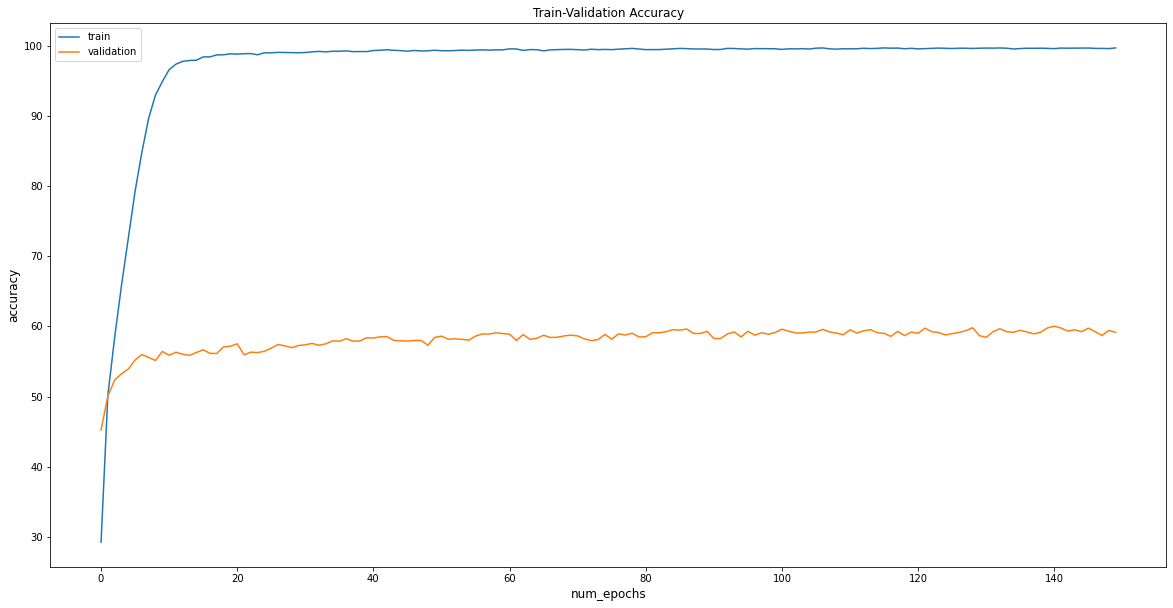

In [8]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

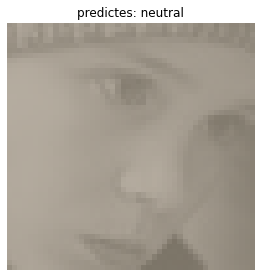

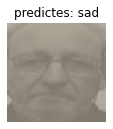

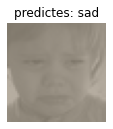

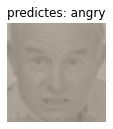

In [9]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()